### PREPARATION

In [4]:
# importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [5]:
# load dataset

data = pd.read_csv('AMZN.csv')
print(data.shape)
print(data.sample(7))

(3019, 7)
            Date    Open    High     Low   Close    Volume  Name
2621  2016-06-03  726.74  727.00  718.43  725.54   3367306  AMZN
1459  2011-10-19  240.67  243.33  229.25  231.53   6715807  AMZN
528   2008-02-08   73.40   74.60   72.52   73.50  11700383  AMZN
312   2007-04-02   39.85   40.47   39.55   40.42   7091398  AMZN
2328  2015-04-07  376.15  379.31  374.03  374.41   1954902  AMZN
886   2009-07-13   78.07   81.65   78.01   81.47   8051114  AMZN
2699  2016-09-23  803.13  807.75  802.12  805.75   2353511  AMZN


In [6]:
# check data info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [8]:
# convert date column dtype object to date

data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB


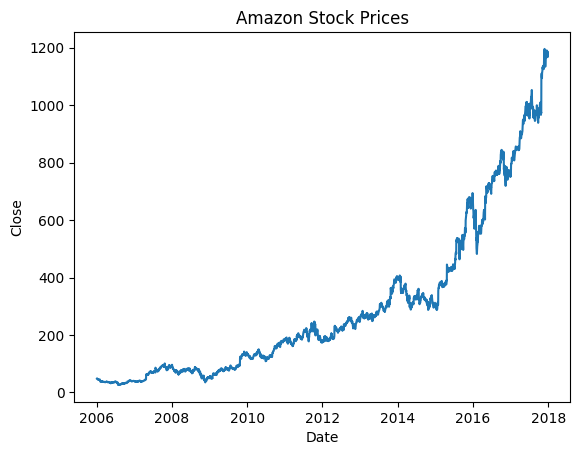

In [15]:
# AMZN stock

plt.plot(data['Date'],data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Amazon Stock Prices")
plt.show()

In [16]:
# define training data length

close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

2869


In [17]:
# scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
# define model

model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000023A739761D0>>

In [19]:
# model compilation and training

model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)

Epoch 1/10
88/88 [==============================] - 6s 33ms/step - loss: 0.0088
Epoch 2/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0026
Epoch 3/10
88/88 [==============================] - 3s 34ms/step - loss: 0.0028
Epoch 4/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0023
Epoch 5/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0023
Epoch 6/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0019
Epoch 7/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0019
Epoch 8/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0018
Epoch 9/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0017
Epoch 10/10
88/88 [==============================] - 3s 33ms/step - loss: 0.0015


In [20]:
# testing data

test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

5/5 [==============================] - 1s 10ms/step
MSE 906.1089110280953
RMSE 30.10164299549271


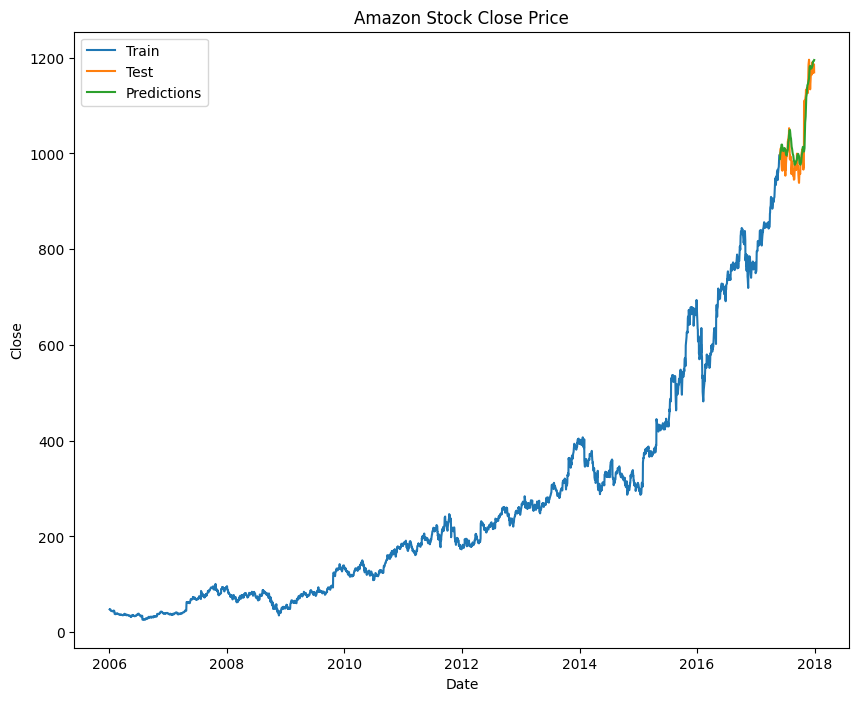

In [23]:
# visualize

train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Amazon Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])